In [91]:
import pandas as pd
import numpy as np
import openreview
import requests
import os
import re
import csv
import pdfplumber
from tqdm import tqdm

In [98]:
"""
def clean_filename(name: str) -> str:
    # remove special characters
    name = re.sub(r'[<>:"/\\|?*]', '', name)
    name = re.sub(r'\s+', '_', name).strip('_')
    return name

def download_neurips_articles():
    try:
        # initialize openreview client
        client = openreview.api.OpenReviewClient(baseurl='https://api2.openreview.net')

        # set up constants
        ACCEPTED_VENUE_ID = 'NeurIPS.cc/2024/Datasets_and_Benchmarks_Track'
        OUTPUT_DIR = 'NeurIPS2024_Datasets_and_Benchmarks'
        METADATA_CSV_FILE = os.path.join(OUTPUT_DIR, 'metadata.csv')

        # make output directory
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        # get all accepted articles
        print(f"Querying openreview for venue ID: {ACCEPTED_VENUE_ID}")
        notes_iterator = openreview.tools.iterget_notes(client, content={'venueid': ACCEPTED_VENUE_ID})

        #notes_iterator = openreview.tools.iterget_notes(client, content={'venueid': ACCEPTED_VENUE_ID})
        all_notes = list(notes_iterator)
        print(f"Total notes retrieved: {len(all_notes)}")

        if not all_notes:
            print("No accepted articles found")
            return

        # downloading pdfs and metadata, extracting fulltext to .csv
        all_metadata = []
        print(f"Downloading {len(all_notes)} articles to '{OUTPUT_DIR}'")

        for note in tqdm(all_notes):
            try:
                title = note.content['title']['value']
                pdf_url_relative = note.content['pdf']['value']

                pdf_url_full = f"https://openreview.net{pdf_url_relative}"
                pdf_filename = f"{clean_filename(title)}.pdf"
                pdf_path = os.path.join(OUTPUT_DIR, pdf_filename)

                # download pdf
                if not os.path.exists(pdf_path):
                    response = requests.get(pdf_url_full, stream=True)
                    response.raise_for_status()
                    with open(pdf_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)

                # extract fulltext
                fulltext = ""
                try:
                    with pdfplumber.open(pdf_path) as pdf:
                        fulltext = "\n".join(page.extract_text() or "" for page in pdf.pages)
                except Exception as e:
                    tqdm.write(f"Error extracting fulltext from {pdf_path}: {e}")
                    fulltext = "Could not extract fulltext"

                # collect metadata
                article_metadata = {
                    'title': title,
                    'keywords': note.content.get('keywords', {}).get('value', []),
                    'openreview_url': f"https://openreview.net/forum?id={note.id}",
                    'pdf_filename': pdf_filename,
                    'fulltext': fulltext
                }
                all_metadata.append(article_metadata)

            except Exception as e:
                tqdm.write(f"Error processing article '{note.content.get('title', {}).get('value', 'Unknown')}': {e}")

        if not all_metadata:
            print("No metadata found")
            return

        # save metadata to .csv
        with open(METADATA_CSV_FILE, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=all_metadata[0].keys())
            writer.writeheader()
            writer.writerows(all_metadata)

        print(f"Metadata saved to '{METADATA_CSV_FILE}'")

    except Exception as e:
        print(f"Error processing articles: {e}")

if __name__ == '__main__':
    download_neurips_articles()
    print("Done")


"""




'\ndef clean_filename(name: str) -> str:\n    # remove special characters\n    name = re.sub(r\'[<>:"/\\|?*]\', \'\', name)\n    name = re.sub(r\'\\s+\', \'_\', name).strip(\'_\')\n    return name\n\ndef download_neurips_articles():\n    try:\n        # initialize openreview client\n        client = openreview.api.OpenReviewClient(baseurl=\'https://api2.openreview.net\')\n\n        # set up constants\n        ACCEPTED_VENUE_ID = \'NeurIPS.cc/2024/Datasets_and_Benchmarks_Track\'\n        OUTPUT_DIR = \'NeurIPS2024_Datasets_and_Benchmarks\'\n        METADATA_CSV_FILE = os.path.join(OUTPUT_DIR, \'metadata.csv\')\n\n        # make output directory\n        os.makedirs(OUTPUT_DIR, exist_ok=True)\n\n        # get all accepted articles\n        print(f"Querying openreview for venue ID: {ACCEPTED_VENUE_ID}")\n        notes_iterator = openreview.tools.iterget_notes(client, content={\'venueid\': ACCEPTED_VENUE_ID})\n\n        #notes_iterator = openreview.tools.iterget_notes(client, content={\'ve

In [13]:
import pandas as pd
df = pd.read_csv('NeurIPS2024_Datasets_and_Benchmarks/metadata.csv')
df.head()

,title,keywords,openreview_url,pdf_filename,fulltext,representation_mentioned,diversity_mentioned,similarity_mentioned
0,DevBench: A multimodal developmental benchmark...,"['multimodal', 'developmental', 'language', 'e...",https://openreview.net/forum?id=zogaeVpbaE,DevBench_A_multimodal_developmental_benchmark_...,DEVBENCH: A multimodal developmental benchmark...,1,1,1
1,Point Cloud Matters: Rethinking the Impact of ...,"['Point Cloud', 'RGB-D images', 'Robot Learnin...",https://openreview.net/forum?id=zgSnSZ0Re6,Point_Cloud_Matters_Rethinking_the_Impact_of_D...,Point Cloud Matters: Rethinking the Impact of\...,1,1,1
2,XLand-MiniGrid: Scalable Meta-Reinforcement Le...,"['reinforcement learning', 'meta-reinforcement...",https://openreview.net/forum?id=zg8dpAGl1I,XLand-MiniGrid_Scalable_Meta-Reinforcement_Lea...,XLand-MiniGrid: Scalable Meta-Reinforcement\nL...,1,1,1
3,kGym: A Platform and Dataset to Benchmark Larg...,"['Benchmarks', 'Datasets', 'Natural Language P...",https://openreview.net/forum?id=zQ3qU0xWZ5,kGym_A_Platform_and_Dataset_to_Benchmark_Large...,KGYM: A Platform and Dataset to Benchmark Larg...,1,1,1
4,$E^3$: Exploring Embodied Emotion Through A La...,['emotion analysis; egocentric datasets ; vide...,https://openreview.net/forum?id=zGfKPqunJG,$E^3$_Exploring_Embodied_Emotion_Through_A_Lar...,E3\n: Exploring Embodied Emotion Through\nA La...,1,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     459 non-null    object
 1   keywords                  459 non-null    object
 2   openreview_url            459 non-null    object
 3   pdf_filename              459 non-null    object
 4   fulltext                  459 non-null    object
 5   representation_mentioned  459 non-null    int64 
 6   diversity_mentioned       459 non-null    int64 
 7   similarity_mentioned      459 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 28.8+ KB


In [15]:
# checking for failed fulltext extractions
empty_mask = df['fulltext'].fillna('').str.strip() == ''
missing_fulltext = df.loc[empty_mask, ['title', 'pdf_filename']]

if missing_fulltext.empty:
    print("No failed fulltext extractions")
else:
    print("Failed fulltext extractions:")
    print(missing_fulltext)

Failed fulltext extractions:
                                                 title  \
180  LINGOLY: A Benchmark of Olympiad-Level Linguis...   

                                          pdf_filename  
180  LINGOLY_A_Benchmark_of_Olympiad-Level_Linguist...  


In [ ]:
"""
# The failed fulltext extraction seems to be image-based. Will use tesseract to extract text instead.
# I will manually input the fulltext into the .csv file, since it is only one article.
import pytesseract
from pdf2image import convert_from_path
import os

def extract_text_from_image_pdf(pdf_path):
    try:
        images = convert_from_path(pdf_path)
        full_text = ""
        for i, image in enumerate(images):
            print(f"   - Reading page {i + 1}/{len(images)}")
            text = pytesseract.image_to_string(image)
            full_text += text + "\n\n" # Add page breaks

        print(full_text)

    except Exception as e:
        print(f"An error occurred during OCR processing: {e}")
        print("Please ensure Tesseract is installed and accessible in your system's PATH.")


if __name__ == "__main__":
    filename = "LINGOLY_A_Benchmark_of_Olympiad-Level_Linguistic_Reasoning_Puzzles_in_Low_Resource_and_Extinct_Languages.pdf"
    folder = "NeurIPS2024_Datasets_and_Benchmarks"
    file_to_process = os.path.join(folder, filename)

    extract_text_from_image_pdf(file_to_process)
"""

In [ ]:
#removing the row where the fulltext is empty
df.to_csv('NeurIPS2024_Datasets_and_Benchmarks/backup_metadata.csv', index=False)

In [16]:
row = df.iloc[180]
print(row['title'])
df.info()

LINGOLY: A Benchmark of Olympiad-Level Linguistic Reasoning Puzzles in Low Resource and Extinct Languages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     459 non-null    object
 1   keywords                  459 non-null    object
 2   openreview_url            459 non-null    object
 3   pdf_filename              459 non-null    object
 4   fulltext                  459 non-null    object
 5   representation_mentioned  459 non-null    int64 
 6   diversity_mentioned       459 non-null    int64 
 7   similarity_mentioned      459 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 28.8+ KB


In [17]:
# SIKRE AT DET ER DET RIGTIGE INDEx!!!!
df = df.drop(df.index[180])

In [18]:
row = df.iloc[180]
print(row['title'])
df.info()

WebUOT-1M: Advancing Deep Underwater Object Tracking with A Million-Scale Benchmark
<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     458 non-null    object
 1   keywords                  458 non-null    object
 2   openreview_url            458 non-null    object
 3   pdf_filename              458 non-null    object
 4   fulltext                  458 non-null    object
 5   representation_mentioned  458 non-null    int64 
 6   diversity_mentioned       458 non-null    int64 
 7   similarity_mentioned      458 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


In [19]:
def add_word_column():
    file_path = os.path.join('NeurIPS2024_Datasets_and_Benchmarks', 'metadata.csv')

    search_terms = {
        'representation_mentioned': r'represent',
        'diversity_mentioned': r'divers',
        'similarity_mentioned': r'similar',
    }

    try:
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path)

        for column_name, pattern in search_terms.items():
            df[column_name] = df['fulltext'].str.contains(
                pattern,
                case=False,
                regex=True
            ).astype(int)

        df.to_csv(file_path, index=False)

        #checking the results
        print(df[['title'] + list(search_terms.keys())].head())

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    add_word_column()

Reading file: NeurIPS2024_Datasets_and_Benchmarks/metadata.csv
                                               title  \
0  DevBench: A multimodal developmental benchmark...   
1  Point Cloud Matters: Rethinking the Impact of ...   
2  XLand-MiniGrid: Scalable Meta-Reinforcement Le...   
3  kGym: A Platform and Dataset to Benchmark Larg...   
4  $E^3$: Exploring Embodied Emotion Through A La...   

   representation_mentioned  diversity_mentioned  similarity_mentioned  
0                         1                    1                     1  
1                         1                    1                     1  
2                         1                    1                     1  
3                         1                    1                     1  
4                         1                    1                     0  


In [20]:
#checking how many articles contain each of the three words and their frequency
word_columns = ['representation_mentioned', 'diversity_mentioned', 'similarity_mentioned']
total_articles = len(df)

for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))

Number of articles containing 'representation_mentioned': 452
Percentage of articles containing 'representation_mentioned': 98.69%
Number of articles containing 'diversity_mentioned': 428
Percentage of articles containing 'diversity_mentioned': 93.45%
Number of articles containing 'similarity_mentioned': 436
Percentage of articles containing 'similarity_mentioned': 95.20%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representation_mentioned  diversity_mentioned  similarity_mentioned  article_count
                        1                    1                     1            407
                        1                    0                     1             24
                        1                    1                     0             17
                        1                    0                     0              4
                        0                    1                     1              3
                        0                    0              

In [ ]:
"""
row = df2.iloc[180]
print(row['title'])
df2.head()
"""

In [21]:
#checking which article uses none of the three words
no_mentions_mask = df[word_columns].sum(axis=1) == 0
articles_with_no_mentions = df[no_mentions_mask]
print(articles_with_no_mentions[['title', 'pdf_filename']])



Empty DataFrame
Columns: [title, pdf_filename]
Index: []


In [22]:
#checking the frequency of different keywords from article metadata
from collections import Counter

cleaned_keywords = (
    df['keywords']
    .str.lower()  #lowercase
    .str.replace(r"[\[\]']", "", regex=True)  #remove brackets and quotes
    .str.split(',')
    .explode()
    .str.strip()  #remove leading/trailing whitespace
)

#counting frequencies
keyword_counts = cleaned_keywords.value_counts()
keyword_counts = keyword_counts[keyword_counts.index != '']
print("Keyword frequencies:")
print(keyword_counts.head(20))

Keyword frequencies:
benchmark                           87
large language models               40
dataset                             40
evaluation                          20
large language model                16
reinforcement learning              15
llms                                15
multimodal                          14
llm                                 13
computer vision                     12
benchmarks                          12
machine learning                    10
vision-language models               9
benchmarking                         8
remote sensing                       8
datasets                             8
graph neural networks                7
multimodal large language models     7
synthetic data                       7
healthcare                           6
Name: keywords, dtype: int64


In [23]:
row = df.iloc[180]
print(row['title'])
df.info()

WebUOT-1M: Advancing Deep Underwater Object Tracking with A Million-Scale Benchmark
<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     458 non-null    object
 1   keywords                  458 non-null    object
 2   openreview_url            458 non-null    object
 3   pdf_filename              458 non-null    object
 4   fulltext                  458 non-null    object
 5   representation_mentioned  458 non-null    int64 
 6   diversity_mentioned       458 non-null    int64 
 7   similarity_mentioned      458 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


In [79]:
def remove_bibliography(text: str) -> str:
    #making sure text is a string
    if not isinstance(text, str):
        return ""

    start_pattern = re.compile(r'(references|bibliography)', re.IGNORECASE | re.MULTILINE)
    end_pattern = re.compile(r'(appendix|appendices|checklist|neurips paper checklist|neuripspaperchecklist|supplementary material|supplementarymaterial|supplementary materials|supplementarymaterials|supplementary content|supplementary contents|supplementarycontent|supplementarycontents|related work|relatedwork|related works|relatedworks|additional dataset information|additionaldatasetinformation|benchmarkdiscussion|implementation details|implementationdetails)', re.IGNORECASE | re.MULTILINE)

    start_match = start_pattern.search(text)

    if not start_match:
        return text

    bib_start_index = start_match.start()
    search_from_index = start_match.end()
    end_match = end_pattern.search(text, pos=search_from_index)


    if end_match:
        bib_end_index = end_match.start()
        #reconstruct text
        text_before_bib = text[:bib_start_index]
        text_after_bib_section = text[bib_end_index:]
        return text_before_bib + text_after_bib_section
    else:
        return text[:bib_start_index]

#creating new column with cleaned text
df['fulltext_no_bib'] = df['fulltext'].apply(remove_bibliography)

#checking if the function works
sample_article = df.iloc[155]
original_length = len(sample_article['fulltext'])
cleaned_length = len(sample_article['fulltext_no_bib'])

print(f"Sample article title: {sample_article['title']}")
print(f"Original fulltext length: {original_length} characters")
print(f"Cleaned fulltext length:  {cleaned_length} characters")
print(f"Characters removed:       {original_length - cleaned_length}")

Sample article title: A Retrospective on the Robot Air Hockey Challenge: Benchmarking Robust, Reliable, and Safe Learning Techniques for Real-world Robotics
Original fulltext length: 109756 characters
Cleaned fulltext length:  95991 characters
Characters removed:       13765


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 458
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       458 non-null    object
 1   keywords                    458 non-null    object
 2   openreview_url              458 non-null    object
 3   pdf_filename                458 non-null    object
 4   fulltext                    458 non-null    object
 5   representation_mentioned    458 non-null    int64 
 6   diversity_mentioned         458 non-null    int64 
 7   similarity_mentioned        458 non-null    int64 
 8   fulltext_no_bib             458 non-null    object
 9   representativity_mentioned  458 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 39.4+ KB


In [44]:
#comparing the fulltext and fulltext_no_bib columns
import difflib

try:
    original_text = sample_article['fulltext']
    cleaned_text = sample_article['fulltext_no_bib']

    diff = difflib.unified_diff(original_text.splitlines(keepends=True), cleaned_text.splitlines(keepends=True), fromfile='original', tofile='no_bib', lineterm='')

    print("Comparison:")
    diff_output = ''.join(diff)
    print(diff_output)

except Exception as e:
    print(f"Error comparing fulltext and fulltext_no_bib: {e}")

Comparison:
--- original+++ no_bib@@ -529,201 +529,6 @@ • SpaceR—AndrejOrsula,MiguelOlivares-Mendez
 • RL3_polimi — Amarildo Likmeta, Amirhossein Zhalehmehrabi, Thomas Jean Bernard
 Bonenfant,AlessandroMontenegro,DavideSalaorni,MarcelloRestelli
-References
-ZhilinYang,ZihangDai,YimingYang,JaimeCarbonell,RussRSalakhutdinov,andQuocVLe.
-Xlnet: Generalizedautoregressivepretrainingforlanguageunderstanding. Advancesinneural
-informationprocessingsystems,32,2019.
-TomBrown,BenjaminMann,NickRyder,MelanieSubbiah,JaredDKaplan,PrafullaDhariwal,
-ArvindNeelakantan,PranavShyam,GirishSastry,AmandaAskell,etal. Languagemodelsare
-few-shotlearners. Advancesinneuralinformationprocessingsystems,33:1877–1901,2020.
-JoshAchiam,StevenAdler,SandhiniAgarwal,LamaAhmad,IlgeAkkaya,FlorenciaLeoniAleman,
-DiogoAlmeida,JankoAltenschmidt,SamAltman,ShyamalAnadkat,etal. Gpt-4technicalreport.
-arXivpreprintarXiv:2303.08774,2023.
-DavidSilver,AjaHuang,ChrisJMaddison,ArthurGuez,LaurentSifre,GeorgeVanDenDriessche,
-Julia

In [26]:
#not perfect... but I think it works for now

In [80]:
#updating word mention columns based on 'fulltext_no_bib'
search_terms = {
    'representativity_mentioned': r'represent',
    'diversity_mentioned': r'divers',
    'similarity_mentioned': r'similar'
}
word_columns = list(search_terms.keys())

df['fulltext_no_bib'] = df['fulltext_no_bib'].astype(str).fillna('')

for column_name, pattern in search_terms.items():
    df[column_name] = df['fulltext_no_bib'].str.contains(
        pattern,
        case=False,
        regex=True
    ).astype(int)

total_articles = len(df)



for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))


Number of articles containing 'representativity_mentioned': 449
Percentage of articles containing 'representativity_mentioned': 98.03%
Number of articles containing 'diversity_mentioned': 421
Percentage of articles containing 'diversity_mentioned': 91.92%
Number of articles containing 'similarity_mentioned': 431
Percentage of articles containing 'similarity_mentioned': 94.10%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representativity_mentioned  diversity_mentioned  similarity_mentioned  article_count
                          1                    1                     1            392
                          1                    0                     1             31
                          1                    1                     0             22
                          0                    1                     1              6
                          1                    0                     0              4
                          0                 

In [28]:
#removing duplicates in keywords column
from collections import Counter

normalization_map = {
    'large language model': 'large language model',
    'large language models': 'large language model',
    'llm': 'large language model',
    'llms': 'large language model',
    'multimodal large language models': 'large language model',
    'benchmark': 'benchmark',
    'benchmarks': 'benchmark',
    'benchmarking': 'benchmark',
    'dataset': 'dataset',
    'datasets': 'dataset',
    'vision-language models': 'vision-language'
}

def normalize_keyword(keyword):
    #normalizing keywords
    return normalization_map.get(keyword, keyword)


cleaned_keywords = (
    df['keywords']
    .str.lower()
    .str.replace(r"[\[\]']", "", regex=True)
    .str.split(',')
    .explode()
    .str.strip()
)

#applying normalization
normalized_keywords = cleaned_keywords.apply(normalize_keyword)

#count frequencies and remove empty strings
keyword_counts_normalized = normalized_keywords.value_counts()
keyword_counts_normalized = keyword_counts_normalized[keyword_counts_normalized.index != '']

print("Updated keyword frequencies:")
print(keyword_counts_normalized.head(20))

Updated keyword frequencies:
benchmark                 107
large language model       91
dataset                    48
evaluation                 20
vision-language            15
reinforcement learning     15
multimodal                 14
computer vision            12
machine learning           10
remote sensing              8
synthetic data              7
graph neural networks       7
healthcare                  6
rag                         6
foundation models           5
alignment                   5
language models             5
code generation             5
robustness                  5
semantic segmentation       5
Name: keywords, dtype: int64


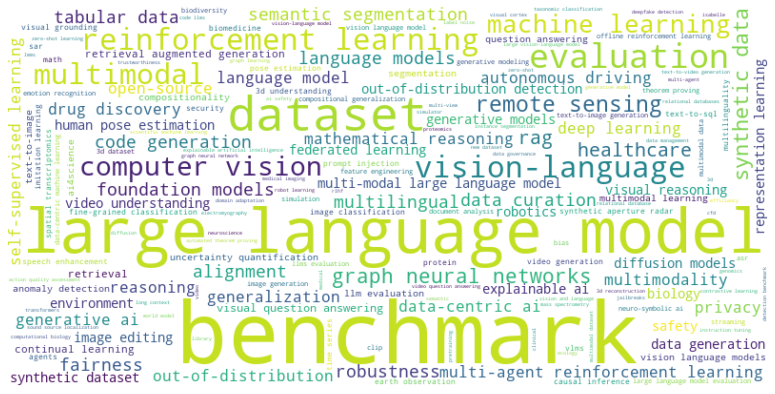

Wordcloud on keywords.


In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    collocations=False
).generate_from_frequencies(keyword_counts_normalized.to_dict())


plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Wordcloud on keywords.")

In [81]:
#updating word mention search with more specific terms
search_terms = {
    'representativity_mentioned': (r'representative sample|data representation|feature representation|'
        r'learned representation|represents the distribution|dataset represents'),
    'diversity_mentioned': r'diversity',
    'similarity_mentioned': r'similarity'
}
word_columns = list(search_terms.keys())

df['fulltext_no_bib'] = df['fulltext_no_bib'].astype(str).fillna('')

for column_name, pattern in search_terms.items():
    df[column_name] = df['fulltext_no_bib'].str.contains(
        pattern,
        case=False,
        regex=True
    ).astype(int)

total_articles = len(df)



for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))


Number of articles containing 'representativity_mentioned': 17
Percentage of articles containing 'representativity_mentioned': 3.71%
Number of articles containing 'diversity_mentioned': 294
Percentage of articles containing 'diversity_mentioned': 64.19%
Number of articles containing 'similarity_mentioned': 212
Percentage of articles containing 'similarity_mentioned': 46.29%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representativity_mentioned  diversity_mentioned  similarity_mentioned  article_count
                          0                    1                     0            147
                          0                    1                     1            135
                          0                    0                     0             96
                          0                    0                     1             63
                          1                    1                     1             11
                          1                   

In [84]:
#Veeery few representativity mentions - need to refine search terms more

In [85]:
#checking if any articles have seen (too) large reductions in corpus size from fulltext to fulltext_no_bib

try:
    len_original = df['fulltext'].str.len()
    len_no_bib = df['fulltext_no_bib'].str.len()

    percentage_reduction = np.divide((len_original - len_no_bib) * 100, len_original, out=np.zeros_like(len_original, dtype=float), where=len_no_bib != 0)

    articles_large_reduction = df[percentage_reduction > 30].copy()
    articles_large_reduction['percentage_reduction'] = percentage_reduction[percentage_reduction > 30]

    if articles_large_reduction.empty:
        print("No articles have seen a large reduction in corpus size from fulltext to fulltext_no_bib.")
    else:
        print(f"\nFound {len(articles_large_reduction)} articles where the removed text was more than 30% of the total:\n")

        print(
            articles_large_reduction[['title', 'percentage_reduction']]
            .sort_values(by='percentage_reduction', ascending=False)
            .round({'percentage_reduction': 1})
            .to_string(index=False)
        )

except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Found 62 articles where the removed text was more than 30% of the total:

                                                                                                                        title  percentage_reduction
                                                      HW-GPT-Bench: Hardware-Aware Architecture Benchmark for Language Models                  72.9
                                                                           Croissant: A Metadata Format for ML-Ready Datasets                  70.0
                               VRSBench: A Versatile Vision-Language Benchmark Dataset for Remote Sensing Image Understanding                  60.8
                                                                                  Multi-modal Situated Reasoning in 3D Scenes                  60.7
DrivAerNet++: A Large-Scale Multimodal Car Dataset with Computational Fluid Dynamics Simulations and Deep Learning Benchmarks                  60.2
                                     

In [83]:
#checking fulltext - have a suspicion there might not be much difference between fulltext and fulltext_no_bib, and the task really is only to refire search terms
search_terms = {
    'representativity_mentioned': (r'representative sample|data representation|feature representation|'
        r'learned representation|represents the distribution|dataset represents'),
    'diversity_mentioned': r'diversity',
    'similarity_mentioned': r'similarity'
}
word_columns = list(search_terms.keys())

df['fulltext'] = df['fulltext'].astype(str).fillna('')

for column_name, pattern in search_terms.items():
    df[column_name] = df['fulltext'].str.contains(
        pattern,
        case=False,
        regex=True
    ).astype(int)

total_articles = len(df)



for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))


Number of articles containing 'representativity_mentioned': 18
Percentage of articles containing 'representativity_mentioned': 3.93%
Number of articles containing 'diversity_mentioned': 303
Percentage of articles containing 'diversity_mentioned': 66.16%
Number of articles containing 'similarity_mentioned': 232
Percentage of articles containing 'similarity_mentioned': 50.66%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representativity_mentioned  diversity_mentioned  similarity_mentioned  article_count
                          0                    1                     1            152
                          0                    1                     0            138
                          0                    0                     0             85
                          0                    0                     1             65
                          1                    1                     1             12
                          1                   

In [86]:
search_terms = {
    'representativity_mentioned': (r'\brepresentation\b|\brepresentative\b|dataset represents|sample represents'),
    'diversity_mentioned': r'diversity',
    'similarity_mentioned': r'similarity'
}
word_columns = list(search_terms.keys())

df['fulltext_no_bib'] = df['fulltext_no_bib'].astype(str).fillna('')

for column_name, pattern in search_terms.items():
    df[column_name] = df['fulltext_no_bib'].str.contains(
        pattern,
        case=False,
        regex=True
    ).astype(int)

total_articles = len(df)

for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))



Number of articles containing 'representativity_mentioned': 164
Percentage of articles containing 'representativity_mentioned': 35.81%
Number of articles containing 'diversity_mentioned': 294
Percentage of articles containing 'diversity_mentioned': 64.19%
Number of articles containing 'similarity_mentioned': 212
Percentage of articles containing 'similarity_mentioned': 46.29%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representativity_mentioned  diversity_mentioned  similarity_mentioned  article_count
                          0                    1                     0            100
                          0                    1                     1             74
                          0                    0                     0             73
                          1                    1                     1             72
                          1                    1                     0             48
                          0                 

In [90]:
term_columns = ['representativity_mentioned', 'diversity_mentioned', 'similarity_mentioned']

all_terms_mask = df[term_columns].sum(axis=1) == len(term_columns)
articles_with_all_terms = df[all_terms_mask]
print(articles_with_all_terms[['title']].to_string(index=False))

                                                                                                                                                                              title
                                                                                                                                  On the Effects of Data Scale on UI Control Agents
                                                                                                   Unraveling Molecular Structure: A Multimodal Spectroscopic Dataset for Chemistry
                                                                                                                                 Intrinsic Self-Supervision for Data Quality Audits
                                                                                                 ComBack: A Versatile Dataset for Enhancing Compiler Backend Development Efficiency
                                                                                                  To

In [96]:
articles_with_all_terms.head(72)

,title,keywords,openreview_url,pdf_filename,fulltext,representation_mentioned,diversity_mentioned,similarity_mentioned,fulltext_no_bib,representativity_mentioned
10,On the Effects of Data Scale on UI Control Agents,"['computer control agents', 'autonomous UI age...",https://openreview.net/forum?id=yUEBXN3cvX,On_the_Effects_of_Data_Scale_on_UI_Control_Age...,On the Effects of Data Scale on\nUI Control Ag...,1,1,1,On the Effects of Data Scale on\nUI Control Ag...,1
18,Unraveling Molecular Structure: A Multimodal S...,"['Multimodal', 'Spectroscopy', 'Chemistry', 'S...",https://openreview.net/forum?id=xjxqWYyTfR,Unraveling_Molecular_Structure_A_Multimodal_Sp...,Unraveling Molecular Structure:\nA Multimodal ...,1,1,1,Unraveling Molecular Structure:\nA Multimodal ...,1
30,Intrinsic Self-Supervision for Data Quality Au...,"['Data Cleaning', 'Data-centric AI', 'Data-cen...",https://openreview.net/forum?id=vvyUa3CDwt,Intrinsic_Self-Supervision_for_Data_Quality_Au...,Intrinsic Self-Supervision for Data Quality Au...,1,1,1,Intrinsic Self-Supervision for Data Quality Au...,1
32,ComBack: A Versatile Dataset for Enhancing Com...,['Compiler Backend; Code Dataset; Code Generat...,https://openreview.net/forum?id=vfju5hjrJw,ComBack_A_Versatile_Dataset_for_Enhancing_Comp...,ComBack: A Versatile Dataset for Enhancing\nCo...,1,1,1,ComBack: A Versatile Dataset for Enhancing\nCo...,1
34,Towards Open Respiratory Acoustic Foundation M...,"['foundation model', 'respiratory audio', 'mac...",https://openreview.net/forum?id=vXnGXRbOfb,Towards_Open_Respiratory_Acoustic_Foundation_M...,Towards Open Respiratory Acoustic Foundation\n...,1,1,1,Towards Open Respiratory Acoustic Foundation\n...,1
...,...,...,...,...,...,...,...,...,...,...
449,DTGB: A Comprehensive Benchmark for Dynamic Te...,['Dynamic Graph; Text-attributed Graph'],https://openreview.net/forum?id=1FVe59t3LX,DTGB_A_Comprehensive_Benchmark_for_Dynamic_Tex...,DTGB: A Comprehensive Benchmark for Dynamic\nT...,1,1,1,DTGB: A Comprehensive Benchmark for Dynamic\nT...,1
451,ProgressGym: Alignment with a Millennium of Mo...,"['Progress Alignment', 'AI Alignment', 'Large ...",https://openreview.net/forum?id=0mRouJElbZ,ProgressGym_Alignment_with_a_Millennium_of_Mor...,ProgressGym: Alignment with a Millennium of\nM...,1,1,1,ProgressGym: Alignment with a Millennium of\nM...,1
453,DMC-VB: A Benchmark for Representation Learnin...,"['representation learning', 'offline reinforce...",https://openreview.net/forum?id=0NQzQVu9tY,DMC-VB_A_Benchmark_for_Representation_Learning...,DMC-VB: A Benchmark for Representation Learnin...,1,1,1,DMC-VB: A Benchmark for Representation Learnin...,1
454,GenAI Arena: An Open Evaluation Platform for G...,"['Evaluation', 'Benchmark', 'Platform', 'Gener...",https://openreview.net/forum?id=0Gmi8TkUC7,GenAI_Arena_An_Open_Evaluation_Platform_for_Ge...,GenAI Arena: An Open Evaluation Platform for\n...,1,1,1,GenAI Arena: An Open Evaluation Platform for\n...,1


In [93]:
normalization_map = {
    'large language model': 'large language model',
    'large language models': 'large language model',
    'llm': 'large language model',
    'llms': 'large language model',
    'multimodal large language models': 'large language model',
    'benchmark': 'benchmark',
    'benchmarks': 'benchmark',
    'benchmarking': 'benchmark',
    'dataset': 'dataset',
    'datasets': 'dataset',
    'vision-language models': 'vision-language'
}

def normalize_keyword(keyword):
    #normalizing keywords
    return normalization_map.get(keyword, keyword)


cleaned_keywords = (
    articles_with_all_terms['keywords']
    .str.lower()
    .str.replace(r"[\[\]']", "", regex=True)
    .str.split(',')
    .explode()
    .str.strip()
)

#applying normalization
normalized_keywords = cleaned_keywords.apply(normalize_keyword)

#count frequencies and remove empty strings
keyword_counts_normalized = normalized_keywords.value_counts()
keyword_counts_normalized = keyword_counts_normalized[keyword_counts_normalized.index != '']

print("Keyword frequencies:")
print(keyword_counts_normalized.head(20))

Keyword frequencies:
large language model        17
benchmark                   13
dataset                      8
multimodal                   4
vision-language              3
synthetic data               3
self-supervised learning     3
biology                      2
privacy                      2
multimodal learning          2
clip                         2
generative model             2
diffusion models             2
machine learning             2
computer vision              2
deep learning                2
new dataset                  2
evaluation                   2
graph neural networks        2
relational databases         2
Name: keywords, dtype: int64


In [ ]:
#TODO
#FINISH ARTICLE CODING/ANNOTATION
#ADD COLUMN WITH PARAGRAPHS WHERE WORDS ARE MENTIONED
#WRITE ARTICLE :))